In [ ]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [5]:
from keras.utils import to_categorical

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [6]:
from keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/0.847.h5')
model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 26s - loss: 0.5456 - acc: 0.8470 - 26s/epoch - 82ms/step


[0.5456120371818542, 0.847000002861023]

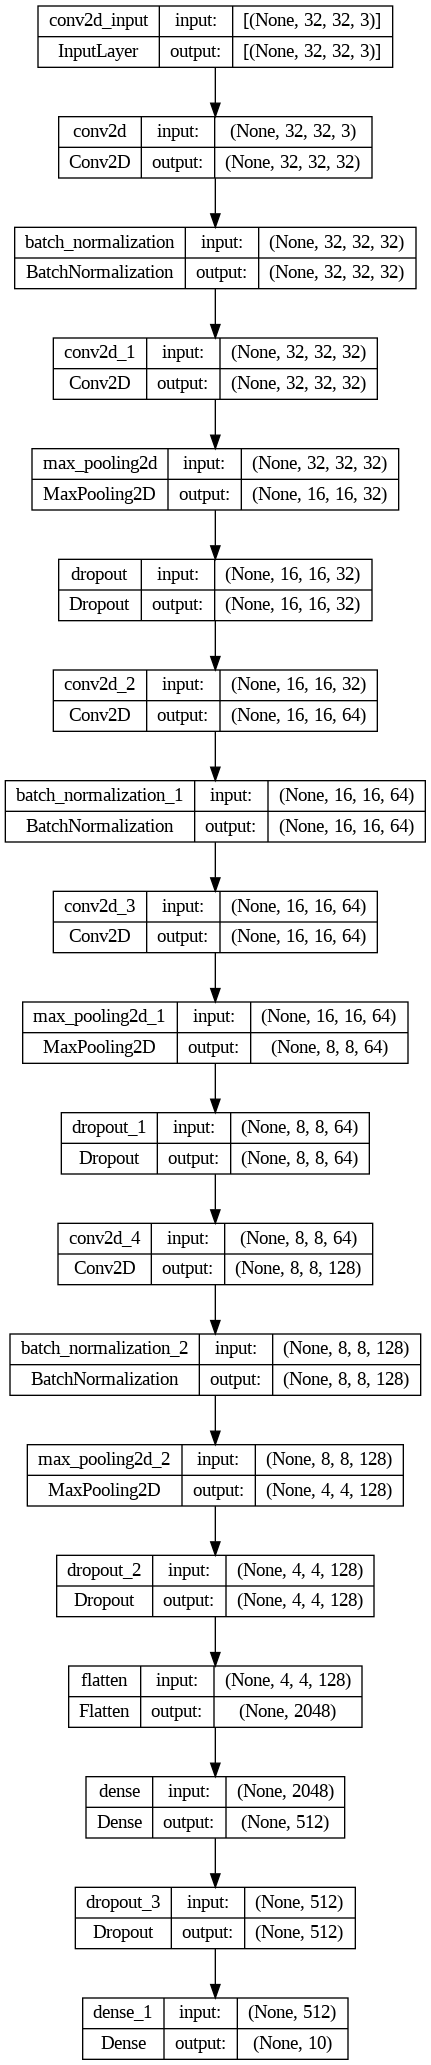

In [8]:
import keras
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=model.input, outputs=model.get_layer('conv2d').output)
intermediate_output = intermediate_model.predict(test_images)

# 차원 축소를 위한 데이터 형태 변경
num_samples, x_shape, y_shape, num_channels = intermediate_output.shape
reshaped_output = np.reshape(intermediate_output, (num_samples, x_shape * y_shape * num_channels))
print(reshaped_output.shape)

# t-SNE에 의한 차원 축소
tsne = TSNE(n_components=2)

313/313 [==============================] - 5s 17ms/step
(10000, 32768)


313/313 [==============================] - 3s 9ms/step
(10000, 32768)


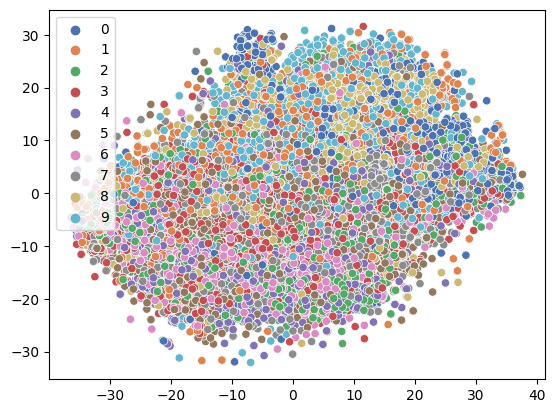

In [ ]:
# 전체 시각화 (약 7분 소요)

tsne_output = tsne.fit_transform(reshaped_output)
sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=np.argmax(test_labels, axis=1), palette='deep')

plt.show()

<Axes: >

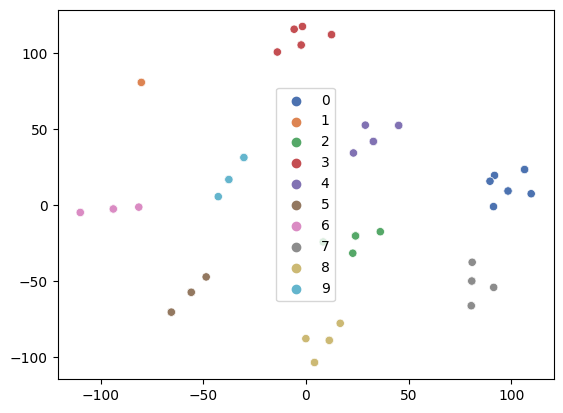

In [ ]:
sample_size = 3000  # 샘플 크기를 조절하면 시간을 줄일 수 있습니다. ~10000
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = reshaped_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output = tsne.fit_transform(sampled_labels)
sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=np.argmax(sampled_labels, axis=1), palette='deep')

In [9]:
import numpy as np
import cv2
from keras import backend as K

def grad_cam(model, target_img, layer_name, label_index):
    cls = np.argmax(label_index)
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])
    output, gradients = gradient_function([target_img])

    output, gradients = output[0, :], gradients[0, :, :, :]
    weights = np.mean(gradients, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (32, 32), interpolation=cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    return heatmap

def display_heatmap(heatmap, original_img_path):
    img = cv2.imread(original_img_path)
    img = cv2.resize(img, (32, 32))

    heatmap = np.uint8(255 * heatmap)
    heatmap_img = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap_img * 0.4 + img
    cv2.imwrite('class_activation_map.jpg', superimposed_img)

target_img = test_images[0]  # 원하는 테스트 이미지의 인덱스로 대체해 주세요.
label_index = test_labels[0]
heatmap = grad_cam(model, np.expand_dims(target_img, axis=0), 'conv2d_4', label_index)
display_heatmap(heatmap, 'heatmap.jpg')  # 실제 원본 이미지 파일 경로로 변경해 주세요.

RuntimeError: ignored